In [1]:
"""
A simple walkthrough of how to code a convolutional neural network (CNN)
using the PyTorch library. For demonstration we train it on the very
common MNIST dataset of handwritten digits. In this code we go through
how to create the network as well as initialize a loss function, optimizer,
check accuracy and more.

Programmed by Aladdin Persson
* 2020-04-08: Initial coding
* 2021-03-24: More detailed comments and small revision of the code

"""

# Imports
import torch
import torchvision # torch package for vision related things
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
from torch.utils.data import DataLoader  # Gives easier dataset managment by creating mini batches etc.
from tqdm import tqdm  # For nice progress bar!

import matplotlib.pyplot as plt
import time
import os
import copy
plt.ion()   # interactive mode




In [7]:
# Simple CNN
class CNN(nn.Module):
    def __init__(self, in_channels=3, num_classes=12):
        super(CNN, self).__init__()

        

        self.conv1 = nn.Conv2d(in_channels=in_channels,out_channels=32,kernel_size=(3, 3), stride=(1, 1))
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=(3, 3),stride=(1, 1))
        self.conv3 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=(3, 3),stride=(1, 1))
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.drp = nn.Dropout(p=0.2)
        self.drp2 = nn.Dropout(p=0.4)


        self.fc1 = nn.Linear(4608,64)  #8192
        
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, num_classes)

        self.relu = nn.ReLU()


        

    def forward(self, x):

        x = F.relu(self.conv1(x)) #cov1
        x = self.pool(x)          #maxpool
        x = self.drp(x)           #droipOut

        x = F.relu(self.conv2(x)) #cov1
        x = self.pool(x)          #maxpool
        x = self.drp(x)           #droipOut

        x = F.relu(self.conv3(x)) #cov1
        x = self.pool(x)          #maxpool
        x = self.drp2(x)          #droipOut
        
        x = torch.flatten(x, 1)   #

        x = x.view(-1,6*6*128)

        x = F.relu(self.fc1(x))   #

        x = F.relu(self.fc2(x))

        x = F.relu(self.fc3(x))

        x = self.fc4(x)
        return x






In [3]:

class block(nn.Module):
    def __init__(
        self, in_channels, intermediate_channels, identity_downsample=None, stride=1
    ):
        super(block, self).__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(
            in_channels, intermediate_channels, kernel_size=1, stride=1, padding=0, bias=False
        )
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False
        )
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(
            block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
            block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
            block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
            block, layers[3], intermediate_channels=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)


def ResNet50(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 4, 6, 3], img_channel, num_classes)


def ResNet101(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 4, 23, 3], img_channel, num_classes)


def ResNet152(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 8, 36, 3], img_channel, num_classes)


def test():
    net = ResNet101(img_channel=3, num_classes=1000)
    y = net(torch.randn(4, 3, 224, 224)).to("cuda")
    print(y.size())

#test()

In [4]:

"""
An implementation of GoogLeNet / InceptionNet from scratch.

Video explanation: https://youtu.be/uQc4Fs7yx5I
Got any questions leave a comment on youtube :)

Programmed by Aladdin Persson <aladdin.persson at hotmail dot com>
*    2020-04-07 Initial coding

"""


class GoogLeNet(nn.Module):
    def __init__(self, aux_logits=True, num_classes=1000):
        super(GoogLeNet, self).__init__()
        assert aux_logits == True or aux_logits == False
        self.aux_logits = aux_logits

        # Write in_channels, etc, all explicit in self.conv1, rest will write to
        # make everything as compact as possible, kernel_size=3 instead of (3,3)
        self.conv1 = conv_block(
            in_channels=3,
            out_channels=64,
            kernel_size=(7, 7),
            stride=(2, 2),
            padding=(3, 3),
        )

        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = conv_block(64, 192, kernel_size=3, stride=1, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # In this order: in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool
        self.inception3a = Inception_block(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception_block(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=(3, 3), stride=2, padding=1)

        self.inception4a = Inception_block(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception_block(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception_block(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception_block(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = Inception_block(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception5a = Inception_block(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception_block(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)
        self.dropout = nn.Dropout(p=0.4)
        self.fc1 = nn.Linear(1024, num_classes)

        if self.aux_logits:
            self.aux1 = InceptionAux(512, num_classes)
            self.aux2 = InceptionAux(528, num_classes)
        else:
            self.aux1 = self.aux2 = None

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        # x = self.conv3(x)
        x = self.maxpool2(x)

        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)

        x = self.inception4a(x)

        # Auxiliary Softmax classifier 1
        if self.aux_logits and self.training:
            aux1 = self.aux1(x)

        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)

        # Auxiliary Softmax classifier 2
        if self.aux_logits and self.training:
            aux2 = self.aux2(x)

        x = self.inception4e(x)
        x = self.maxpool4(x)
        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.dropout(x)
        x = self.fc1(x)

        if self.aux_logits and self.training:
            return aux1, aux2, x
        else:
            return x


class Inception_block(nn.Module):
    def __init__(
        self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool
    ):
        super(Inception_block, self).__init__()
        self.branch1 = conv_block(in_channels, out_1x1, kernel_size=(1, 1))

        self.branch2 = nn.Sequential(
            conv_block(in_channels, red_3x3, kernel_size=(1, 1)),
            conv_block(red_3x3, out_3x3, kernel_size=(3, 3), padding=(1, 1)),
        )

        self.branch3 = nn.Sequential(
            conv_block(in_channels, red_5x5, kernel_size=(1, 1)),
            conv_block(red_5x5, out_5x5, kernel_size=(5, 5), padding=(2, 2)),
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            conv_block(in_channels, out_1x1pool, kernel_size=(1, 1)),
        )

    def forward(self, x):
        return torch.cat(
            [self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)], 1
        )


class InceptionAux(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(InceptionAux, self).__init__()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.7)
        self.pool = nn.AvgPool2d(kernel_size=5, stride=3)
        self.conv = conv_block(in_channels, 128, kernel_size=1)
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.pool(x)
        x = self.conv(x)
        x = x.reshape(x.shape[0], -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x


class conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(conv_block, self).__init__()
        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        return self.relu(self.batchnorm(self.conv(x)))


"""if __name__ == "__main__":
    # N = 3 (Mini batch size)
    x = torch.randn(3, 3, 224, 224)
    model = GoogLeNet(aux_logits=True, num_classes=1000)
    print(model(x)[2].shape)"""

'if __name__ == "__main__":\n    # N = 3 (Mini batch size)\n    x = torch.randn(3, 3, 224, 224)\n    model = GoogLeNet(aux_logits=True, num_classes=1000)\n    print(model(x)[2].shape)'

In [5]:
# Simple CNN
class CNN(nn.Module):
    def __init__(self, in_channels=3, num_classes=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=8,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv2 = nn.Conv2d(
            in_channels=8,
            out_channels=16,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.fc1 = nn.Linear(16 * 7 * 7, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        return x



In [6]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device="cpu"
# Hyperparameters
in_channels = 3
num_classes = 12
learning_rate = 0.001
batch_size = 64
num_epochs = 20


trainDir="/home/adebolajo/PycharmProjects/NemoV2/datasets/train"
valDir="/home/adebolajo/PycharmProjects/NemoV2/datasets/val"
testnDir="/home/adebolajo/PycharmProjects/NemoV2/datasets/test"


transform = transforms.Compose(
    [transforms.Resize(64), transforms.CenterCrop(64), transforms.ToTensor()]
)

# Load Data
train_dataset = datasets.ImageFolder(root=trainDir, transform=transform)
test_dataset = datasets.ImageFolder(root=testnDir, transform=transform)
val_dataset = datasets.ImageFolder(root=valDir, transform=transform)



train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)


In [8]:
#model = ResNet101(img_channel=in_channels, num_classes=num_classes).to(device)

#model = GoogLeNet(aux_logits=False, num_classes=num_classes).cuda()

# Initialize network
model = CNN(in_channels=in_channels, num_classes=num_classes).to(device)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
train_losses=[]
train_accu=[]

def trainT():
    running_loss=0
    correct=0
    total=0
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
        # Get data to cuda if possible
        data = data.cuda()
        targets = targets.cuda()

        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

        running_loss += loss.item()
     
        _, predicted = scores.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
    train_loss=running_loss/len(train_loader)
    accu=100.*correct/total
    
    train_accu.append(accu)
    train_losses.append(train_loss)
    print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))


In [10]:

val_losses=[]
val_accu=[]

def valT(loader):
    running_loss=0
    correct=0
    total=0
    for batch_idx, (data, targets) in enumerate(tqdm(loader)):
        # Get data to cuda if possible
        data = data.cuda()
        targets = targets.cuda()

        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        running_loss+=loss.item()
       
        _, predicted = scores.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    test_loss=running_loss/len(loader)
    accu=100.*correct/total
    
    val_losses.append(test_loss)
    val_accu.append(accu)
    
    print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu)) 






In [11]:

num_epochs = 25

# Train Network
for epoch in range(num_epochs):
    print("epoch..........................."+str(epoch))
    model.train()
    trainT()
    model.eval()
    valT(val_loader)
    



epoch...........................0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:15<00:00, 13.74it/s]


Train Loss: 2.038 | Accuracy: 29.820


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:03<00:00, 14.90it/s]


Test Loss: 1.605 | Accuracy: 46.283
epoch...........................1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:12<00:00, 16.93it/s]


Train Loss: 1.223 | Accuracy: 58.619


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 18.88it/s]


Test Loss: 0.965 | Accuracy: 66.897
epoch...........................2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:12<00:00, 17.36it/s]


Train Loss: 0.841 | Accuracy: 71.381


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 19.14it/s]


Test Loss: 0.713 | Accuracy: 75.203
epoch...........................3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:12<00:00, 17.15it/s]


Train Loss: 0.653 | Accuracy: 77.538


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 19.35it/s]


Test Loss: 0.537 | Accuracy: 81.312
epoch...........................4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:12<00:00, 16.87it/s]


Train Loss: 0.517 | Accuracy: 82.065


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 18.90it/s]


Test Loss: 0.463 | Accuracy: 84.081
epoch...........................5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:20<00:00, 10.40it/s]


Train Loss: 0.472 | Accuracy: 83.656


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:03<00:00, 14.32it/s]


Test Loss: 0.372 | Accuracy: 87.120
epoch...........................6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:21<00:00,  9.61it/s]


Train Loss: 0.402 | Accuracy: 86.359


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:03<00:00, 15.85it/s]


Test Loss: 0.439 | Accuracy: 85.405
epoch...........................7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:20<00:00,  9.97it/s]


Train Loss: 0.350 | Accuracy: 87.635


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:03<00:00, 14.60it/s]


Test Loss: 0.323 | Accuracy: 88.986
epoch...........................8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:21<00:00,  9.71it/s]


Train Loss: 0.324 | Accuracy: 88.859


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:03<00:00, 15.66it/s]


Test Loss: 0.301 | Accuracy: 90.190
epoch...........................9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:20<00:00, 10.11it/s]


Train Loss: 0.319 | Accuracy: 88.874


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:03<00:00, 16.04it/s]


Test Loss: 0.334 | Accuracy: 88.354
epoch...........................10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:32<00:00,  6.38it/s]


Train Loss: 0.290 | Accuracy: 89.820


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:05<00:00,  9.29it/s]


Test Loss: 0.396 | Accuracy: 86.277
epoch...........................11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:38<00:00,  5.39it/s]


Train Loss: 0.258 | Accuracy: 90.833


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:07<00:00,  7.38it/s]


Test Loss: 0.357 | Accuracy: 87.541
epoch...........................12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:39<00:00,  5.35it/s]


Train Loss: 0.261 | Accuracy: 91.104


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:07<00:00,  6.80it/s]


Test Loss: 0.215 | Accuracy: 92.717
epoch...........................13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:39<00:00,  5.35it/s]


Train Loss: 0.224 | Accuracy: 92.335


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:07<00:00,  6.75it/s]


Test Loss: 0.217 | Accuracy: 92.266
epoch...........................14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:39<00:00,  5.33it/s]


Train Loss: 0.205 | Accuracy: 92.583


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:07<00:00,  6.69it/s]


Test Loss: 0.222 | Accuracy: 91.965
epoch...........................15


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:39<00:00,  5.23it/s]


Train Loss: 0.202 | Accuracy: 93.228


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:04<00:00, 10.47it/s]


Test Loss: 0.214 | Accuracy: 92.657
epoch...........................16


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:12<00:00, 16.99it/s]


Train Loss: 0.177 | Accuracy: 93.889


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 18.26it/s]


Test Loss: 0.458 | Accuracy: 85.826
epoch...........................17


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:12<00:00, 17.11it/s]


Train Loss: 0.178 | Accuracy: 93.911


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 19.21it/s]


Test Loss: 0.223 | Accuracy: 92.356
epoch...........................18


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:12<00:00, 17.11it/s]


Train Loss: 0.164 | Accuracy: 94.347


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 18.92it/s]


Test Loss: 0.197 | Accuracy: 93.440
epoch...........................19


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:12<00:00, 17.23it/s]


Train Loss: 0.160 | Accuracy: 94.227


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 17.78it/s]


Test Loss: 0.198 | Accuracy: 93.169
epoch...........................20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:12<00:00, 17.08it/s]


Train Loss: 0.148 | Accuracy: 95.075


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 19.03it/s]


Test Loss: 0.255 | Accuracy: 91.423
epoch...........................21


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:12<00:00, 16.89it/s]


Train Loss: 0.139 | Accuracy: 95.263


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 18.39it/s]


Test Loss: 0.384 | Accuracy: 87.421
epoch...........................22


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:12<00:00, 16.91it/s]


Train Loss: 0.149 | Accuracy: 94.737


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 19.12it/s]


Test Loss: 0.241 | Accuracy: 92.236
epoch...........................23


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:12<00:00, 16.88it/s]


Train Loss: 0.118 | Accuracy: 95.931


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 18.97it/s]


Test Loss: 0.174 | Accuracy: 93.711
epoch...........................24


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:12<00:00, 16.82it/s]


Train Loss: 0.111 | Accuracy: 96.081


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 18.41it/s]

Test Loss: 0.178 | Accuracy: 94.222


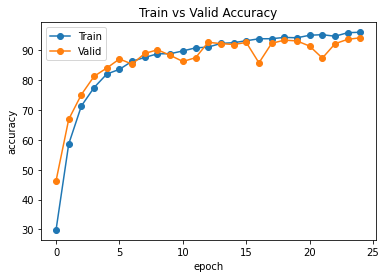

In [12]:
plt.plot(train_accu,'-o')
plt.plot(val_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')
 
plt.show()

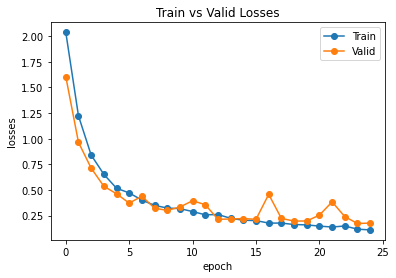

In [13]:
plt.plot(train_losses,'-o')
plt.plot(val_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')
 
plt.show()

In [36]:
# Check accuracy on training & test to see how good our model
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)


    model.train()
    return num_correct/num_samples


print(f"Accuracy on training set: {check_accuracy(train_loader, model)*100:.2f}")
print(f"Accuracy on test set: {check_accuracy(test_loader, model)*100:.2f}")

Accuracy on training set: 98.51
Accuracy on test set: 94.30


In [25]:
PATH = "/home/adebolajo/PycharmProjects/NemoV2/model_amaNet.pt"

In [26]:
torch.save(model.state_dict(), PATH)

In [ ]:
model = CNN(in_channels=in_channels, num_classes=num_classes).to(device)
model.load_state_dict(torch.load(PATH))
model.eval()

In [33]:
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [34]:
model.eval()

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (drp): Dropout(p=0.2, inplace=False)
  (drp2): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=4608, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=12, bias=True)
  (relu): ReLU()
)

In [35]:
print(f"Accuracy on training set: {check_accuracy(train_loader, model)*100:.2f}")
print(f"Accuracy on test set: {check_accuracy(test_loader, model)*100:.2f}")

Accuracy on training set: 98.51
Accuracy on test set: 94.30
